Mounting Google Drive

In [ ]:
# Mount your google drive in google colab
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import sys
sys.path.insert(0,'/content/drive/My Drive/Colab Notebooks/Session 7')

In [ ]:

pip install torchsummary

  Using cached torchsummary-1.5.1-py3-none-any.whl (2.8 kB)
Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\Rashi Agarwal\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


Importing libraries

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchsummary import summary
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR
%matplotlib inline

Updating Device to CUDA

In [ ]:
# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)
device = torch.device("cuda" if cuda else "cpu") #c2

CUDA Available? True


Importing custom modules

In [ ]:
import utils
import model

In [ ]:
from utils import   (
 plot_graphs,
 plots,
 plt,
 torch,
 tqdm
 )

In [ ]:
from model import (F,
  Net,nn,torch)

Defining data tranformations

In [ ]:
train_transforms = transforms.Compose([
   #transforms.RandomApply([transforms.CenterCrop(22), ], p=0.1),
    #transforms.Resize((28, 28)),
    #transforms.RandomRotation((-15., 15.), fill=0),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    ])
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])


Downloading MNIST dataset and splitting to train and test set

In [ ]:
train_data = datasets.MNIST('../data', train=True, download=True, transform=train_transforms)
test_data = datasets.MNIST('../data', train=False, download=True, transform=test_transforms)

100%|██████████| 9912422/9912422 [00:00<00:00, 342861358.92it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 12108725.89it/s]


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 155967060.50it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw




100%|██████████| 4542/4542 [00:00<00:00, 16963961.50it/s]


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



Creating Data Loaders from train data and test data

In [ ]:
batch_size = 512

kwargs = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 2, 'pin_memory': True}

test_loader = torch.utils.data.DataLoader(test_data, **kwargs)
train_loader = torch.utils.data.DataLoader(train_data, **kwargs)

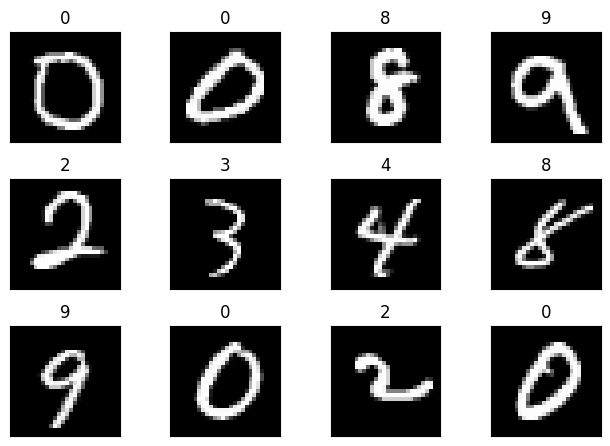

In [ ]:
plots(train_loader)

## Data Statistics

torch.Size([512, 1, 28, 28])
torch.Size([512])


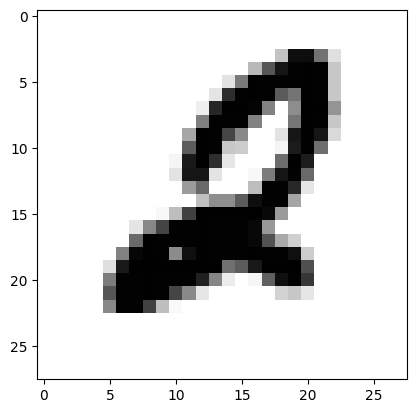

In [ ]:
# train_data1 = train_data.train_data
# train_data = train_data.transform(train_data1.numpy())

# print('[Train]')
# print(' - Numpy Shape:', train_data.train_data.cpu().numpy().shape)
# print(' - Tensor Shape:', train_data.train_data.size())
# print(' - min:', torch.min(train_data))
# print(' - max:', torch.max(train_data))
# print(' - mean:', torch.mean(train_data))
# print(' - std:', torch.std(train_data))
# print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')

Viewing images

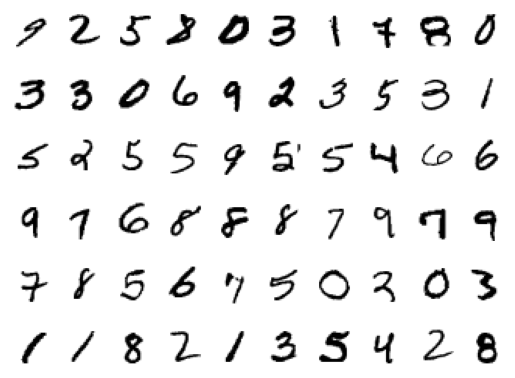

In [ ]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

Transferring model to GPU and printing model summary

In [ ]:
model1 = Net().to(device)
summary(model1, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
              ReLU-2           [-1, 10, 26, 26]               0
            Conv2d-3           [-1, 16, 24, 24]           1,440
              ReLU-4           [-1, 16, 24, 24]               0
            Conv2d-5           [-1, 16, 22, 22]           2,304
              ReLU-6           [-1, 16, 22, 22]               0
         MaxPool2d-7           [-1, 16, 11, 11]               0
            Conv2d-8           [-1, 16, 11, 11]             256
              ReLU-9           [-1, 16, 11, 11]               0
           Conv2d-10             [-1, 24, 9, 9]           3,456
             ReLU-11             [-1, 24, 9, 9]               0
           Conv2d-12             [-1, 24, 7, 7]           5,184
             ReLU-13             [-1, 24, 7, 7]               0
           Conv2d-14             [-1, 1

In [ ]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

Training and evaluating the model

In [ ]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


Loss=2.3022854328155518 Batch_id=117 Accuracy=12.18: 100%|██████████| 118/118 [00:19<00:00,  5.99it/s]



Test set: Average loss: 2.3023, Accuracy: 1261/10000 (12.61%)

EPOCH: 1


Loss=2.3014075756073 Batch_id=117 Accuracy=12.60: 100%|██████████| 118/118 [00:13<00:00,  8.45it/s]



Test set: Average loss: 2.3012, Accuracy: 1339/10000 (13.39%)

EPOCH: 2


Loss=2.3024227619171143 Batch_id=117 Accuracy=24.06: 100%|██████████| 118/118 [00:14<00:00,  8.31it/s]



Test set: Average loss: 2.3023, Accuracy: 2173/10000 (21.73%)

EPOCH: 3


Loss=2.3021912574768066 Batch_id=117 Accuracy=22.90: 100%|██████████| 118/118 [00:14<00:00,  8.34it/s]



Test set: Average loss: 2.3023, Accuracy: 2478/10000 (24.78%)

EPOCH: 4


Loss=2.3020946979522705 Batch_id=117 Accuracy=25.80: 100%|██████████| 118/118 [00:14<00:00,  8.39it/s]



Test set: Average loss: 2.3019, Accuracy: 2843/10000 (28.43%)

EPOCH: 5


Loss=2.298232078552246 Batch_id=117 Accuracy=28.76: 100%|██████████| 118/118 [00:14<00:00,  8.26it/s]



Test set: Average loss: 2.2977, Accuracy: 3105/10000 (31.05%)

EPOCH: 6


Loss=2.080110788345337 Batch_id=117 Accuracy=36.80: 100%|██████████| 118/118 [00:13<00:00,  8.52it/s]



Test set: Average loss: 1.9174, Accuracy: 4470/10000 (44.70%)

EPOCH: 7


Loss=0.3657502830028534 Batch_id=117 Accuracy=74.54: 100%|██████████| 118/118 [00:14<00:00,  8.28it/s]



Test set: Average loss: 0.3929, Accuracy: 8755/10000 (87.55%)

EPOCH: 8


Loss=0.2503226399421692 Batch_id=117 Accuracy=89.81: 100%|██████████| 118/118 [00:14<00:00,  8.29it/s]



Test set: Average loss: 0.2698, Accuracy: 9123/10000 (91.23%)

EPOCH: 9


Loss=0.25744983553886414 Batch_id=117 Accuracy=92.89: 100%|██████████| 118/118 [00:14<00:00,  8.19it/s]



Test set: Average loss: 0.1935, Accuracy: 9373/10000 (93.73%)

EPOCH: 10


Loss=0.1518547087907791 Batch_id=117 Accuracy=94.67: 100%|██████████| 118/118 [00:14<00:00,  8.31it/s]



Test set: Average loss: 0.1384, Accuracy: 9573/10000 (95.73%)

EPOCH: 11


Loss=0.2183438390493393 Batch_id=117 Accuracy=95.61: 100%|██████████| 118/118 [00:16<00:00,  7.03it/s]



Test set: Average loss: 0.1144, Accuracy: 9671/10000 (96.71%)

EPOCH: 12


Loss=0.1509724110364914 Batch_id=117 Accuracy=96.44: 100%|██████████| 118/118 [00:14<00:00,  8.21it/s]



Test set: Average loss: 0.0994, Accuracy: 9692/10000 (96.92%)

EPOCH: 13


Loss=0.15166659653186798 Batch_id=117 Accuracy=96.79: 100%|██████████| 118/118 [00:14<00:00,  8.34it/s]



Test set: Average loss: 0.0927, Accuracy: 9716/10000 (97.16%)

EPOCH: 14


Loss=0.15421625971794128 Batch_id=117 Accuracy=97.20: 100%|██████████| 118/118 [00:14<00:00,  8.39it/s]



Test set: Average loss: 0.0960, Accuracy: 9709/10000 (97.09%)

EPOCH: 15


Loss=0.026438258588314056 Batch_id=117 Accuracy=97.39: 100%|██████████| 118/118 [00:14<00:00,  8.36it/s]



Test set: Average loss: 0.0800, Accuracy: 9762/10000 (97.62%)

EPOCH: 16


Loss=0.028544435277581215 Batch_id=117 Accuracy=97.75: 100%|██████████| 118/118 [00:14<00:00,  8.06it/s]



Test set: Average loss: 0.0682, Accuracy: 9786/10000 (97.86%)

EPOCH: 17


Loss=0.04973144456744194 Batch_id=117 Accuracy=97.88: 100%|██████████| 118/118 [00:14<00:00,  8.39it/s]



Test set: Average loss: 0.0613, Accuracy: 9803/10000 (98.03%)

EPOCH: 18


Loss=0.03246553614735603 Batch_id=117 Accuracy=98.06: 100%|██████████| 118/118 [00:14<00:00,  8.31it/s]



Test set: Average loss: 0.0594, Accuracy: 9816/10000 (98.16%)

EPOCH: 19


Loss=0.05532228946685791 Batch_id=117 Accuracy=98.18: 100%|██████████| 118/118 [00:14<00:00,  8.23it/s]



Test set: Average loss: 0.0629, Accuracy: 9812/10000 (98.12%)



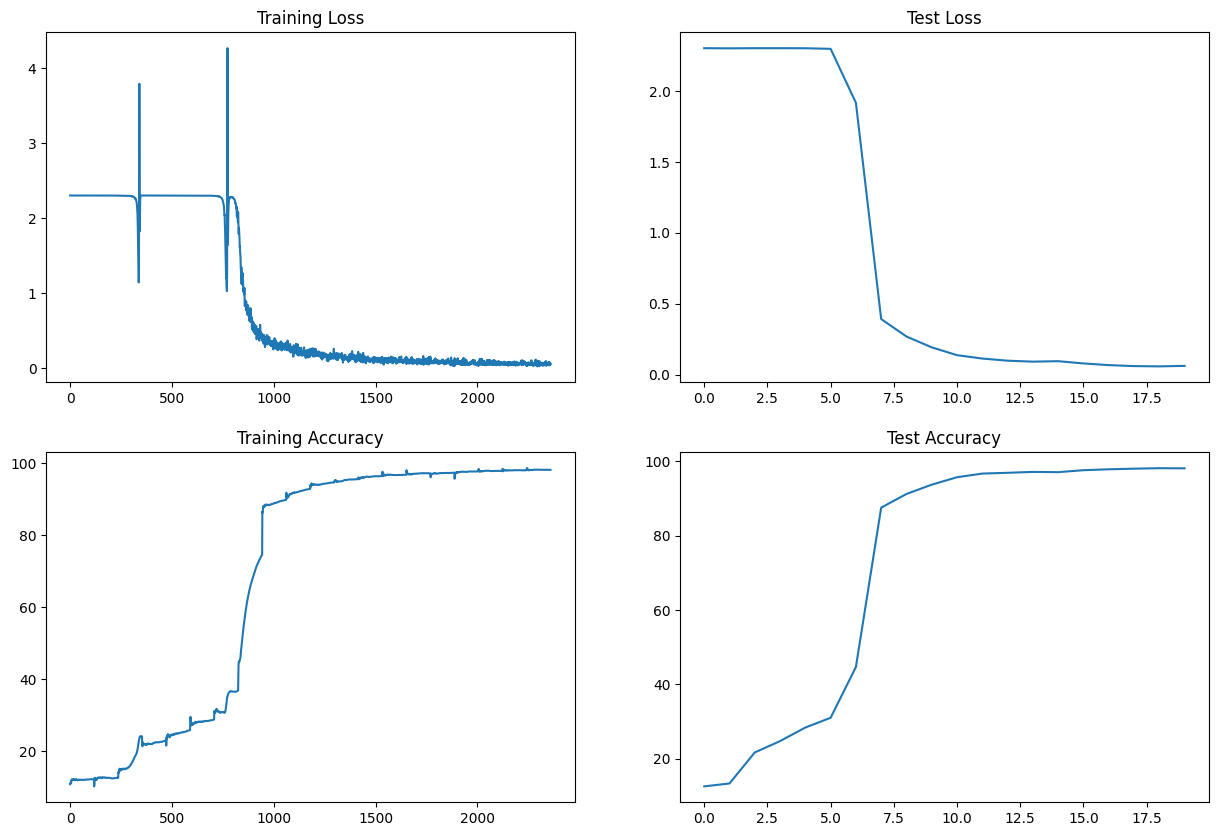

In [ ]:
train_losses = [t_items.item() for t_items in train_losses]
plot_graphs(train_losses, train_acc, test_losses ,test_acc)

# Target:

Making the model lighter by reducing parameters

#Results:
Parameters: 20K

Best Training Accuracy: 98.18

Best Test Accuracy: 98.16

#Analysis:
Light Model but working

Model is not over-fitting. Efficiency can be increased by using Batch normalization in next step